<a href="https://colab.research.google.com/github/JackJ-C/double-helix-vision-tool/blob/main/DH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 安装/更新基础库
!pip install numpy opencv-python matplotlib scikit-image

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from IPython.display import display, Markdown

print("OK✅")

OK✅


In [ ]:
class DoubleHelixVisionTool:

    def __init__(self, width=1920, height=1080):

        """

        初始化工具：确立视界尺寸

        """

        self.width = width

        self.height = height

        self.center_x = width // 2

        self.center_y = height // 2



        # 1. 四角定位 (Four-Corner Positioning)

        # 定义视锥体的最外层切片 (近景平面 Near Plane)

        self.corners = np.array([

            [0, 0],           # 左上 (TL)

            [width, 0],       # 右上 (TR)

            [width, height],  # 右下 (BR)

            [0, height]       # 左下 (BL)

        ])



        # 2. 预计算双螺旋路径 (Double Helix Rifling)

        # 只需要计算一次，极大节省后续处理算力

        self._init_spiral_path()



    def _init_spiral_path(self):

        """

        生成黄金螺旋膛线路径

        """

        # 参数设定：决定采样密度和视锥角度

        num_points = 3000   # 采样点数

        rotations = 8       # 旋转圈数

        growth_factor = 0.55 # 决定螺旋张开的速度 (模拟透视)



        # 最大的采样半径 (也就是从中心到四角的距离)

        max_radius = min(self.width, self.height) / 1.8



        # 生成角度 (Theta)

        thetas = np.linspace(0, rotations * 2 * np.pi, num_points)



        # 生成半径 (Radius) - 基于指数增长，模拟中心密集(远)、边缘稀疏(近)

        # 加上 1e-9 防止除零

        radii = max_radius * (thetas / (thetas[-1] + 1e-9)) ** growth_factor



        # --- 螺旋 Alpha (顺时针) ---

        self.x_a = (self.center_x + radii * np.cos(thetas)).astype(int)

        self.y_a = (self.center_y + radii * np.sin(thetas)).astype(int)



        # --- 螺旋 Beta (逆时针/相位差 180度) ---

        # 通过增加 Pi 实现双螺旋纠缠

        self.x_b = (self.center_x + radii * np.cos(thetas + np.pi)).astype(int)

        self.y_b = (self.center_y + radii * np.sin(thetas + np.pi)).astype(int)



        # 保存半径数据用于深感计算 (Radius 越小 = 离中心越近 = 距离越远)

        self.depth_map = radii



        # 创建有效点掩码 (过滤掉超出四角范围的点)

        self.valid_mask = (

            (self.x_a >= 0) & (self.x_a < self.width) &

            (self.y_a >= 0) & (self.y_a < self.height) &

            (self.x_b >= 0) & (self.x_b < self.width) &

            (self.y_b >= 0) & (self.y_b < self.height)

        )



        # 提取有效坐标，供后续快速索引

        self.idx_xa = self.x_a[self.valid_mask]

        self.idx_ya = self.y_a[self.valid_mask]

        self.idx_xb = self.x_b[self.valid_mask]

        self.idx_yb = self.y_b[self.valid_mask]

        self.valid_depth = self.depth_map[self.valid_mask]



    def scan(self, frame_path_or_array):

        """

        核心功能：执行一次视觉扫描

        """

        # 输入处理：支持文件路径或直接传入数组

        if isinstance(frame_path_or_array, str):

            frame = cv2.imread(frame_path_or_array)

            if frame is None:

                raise ValueError("无法读取图片路径")

        else:

            frame = frame_path_or_array



        # 强制缩放到初始化尺寸 (保持四角定位准确)

        if (frame.shape[1] != self.width) or (frame.shape[0] != self.height):

            frame = cv2.resize(frame, (self.width, self.height))



        # 转灰度 (只取亮度信息，极大提升速度)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)



        # --- 极速采样 (Rifling Sampling) ---

        # 利用 Numpy 高级索引，瞬间提取几千个点

        signal_alpha = gray[self.idx_ya, self.idx_xa]

        signal_beta  = gray[self.idx_yb, self.idx_xb]



        # 返回结构化数据流

        return {

            "alpha_stream": signal_alpha, # 螺旋A的亮度流

            "beta_stream":  signal_beta,  # 螺旋B的亮度流

            "depth_stream": self.valid_depth, # 对应的视锥半径 (可换算为Z轴深度)

            "original_img": frame # 返回原图用于可视化

        }

In [ ]:
import time
import numpy as np
from IPython.display import display, Markdown

np.random.seed(0)

W, H = 1920, 1080
gray_test = np.random.randint(0, 256, (H, W), dtype=np.uint8)

N_list = [500, 1000, 3000, 6000]
runs = 1000
warmup = 100
batches = 5

def set_budget_indices(tool, N, rotations=8, growth_factor=0.55):
    cx, cy = tool.center_x, tool.center_y

    # 关键：用内切圆半径，保证不会越界 => 有效点数基本等于 N
    r_max = min(cx, cy) - 1

    thetas = np.linspace(0, rotations * 2 * np.pi, N, dtype=np.float32)
    radii  = r_max * (thetas / (thetas[-1] + 1e-9)) ** growth_factor

    xa = (cx + radii * np.cos(thetas)).astype(np.int32)
    ya = (cy + radii * np.sin(thetas)).astype(np.int32)
    xb = (cx + radii * np.cos(thetas + np.pi)).astype(np.int32)
    yb = (cy + radii * np.sin(thetas + np.pi)).astype(np.int32)

    # 保险 clip（理论上不会出界）
    xa = np.clip(xa, 0, tool.width - 1)
    ya = np.clip(ya, 0, tool.height - 1)
    xb = np.clip(xb, 0, tool.width - 1)
    yb = np.clip(yb, 0, tool.height - 1)

    tool.idx_xa, tool.idx_ya = xa, ya
    tool.idx_xb, tool.idx_yb = xb, yb
    tool.valid_depth = radii.astype(np.float32)

results = []
for N in N_list:
    tool = DoubleHelixVisionTool(W, H)  # 你原来的类，保持不动
    set_budget_indices(tool, N)

    # 局部绑定，减少 Python 属性查找开销（更稳）
    xa, ya = tool.idx_xa, tool.idx_ya
    xb, yb = tool.idx_xb, tool.idx_yb
    g = gray_test

    def scan_pure():
        _ = g[ya, xa]
        _ = g[yb, xb]

    # warmup
    for _ in range(warmup):
        scan_pure()

    times = []
    for _ in range(batches):
        t0 = time.perf_counter_ns()
        for _ in range(runs):
            scan_pure()
        t1 = time.perf_counter_ns()
        times.append((t1 - t0) / 1e6 / runs)  # ms/frame

    ms_mean = float(np.mean(times))
    ms_std  = float(np.std(times, ddof=1))
    n_eff = int(len(xa))
    ratio = n_eff / N

    results.append((N, n_eff, ratio, ms_mean, ms_std))

header = "| N(请求) | N(有效) | 有效率 n_eff/N | 纯采样耗时 (ms) | 理论 FPS |"
sep = "| :---: | :---: | :---: | :---: | :---: |"
rows = [
    f"| {N} | {n_eff} | {ratio:.3f} | {ms:.6f} ± {sd:.6f} | {1000/ms:.1f} |"
    for N, n_eff, ratio, ms, sd in results
]
display(Markdown(f"### DH Efficiency \n\n{header}\n{sep}\n" + "\n".join(rows)))


### DH Efficiency 

| N(请求) | N(有效) | 有效率 n_eff/N | 纯采样耗时 (ms) | 理论 FPS |
| :---: | :---: | :---: | :---: | :---: |
| 500 | 500 | 1.000 | 0.010942 ± 0.000202 | 91388.1 |
| 1000 | 1000 | 1.000 | 0.016841 ± 0.000108 | 59380.4 |
| 3000 | 3000 | 1.000 | 0.041245 ± 0.000832 | 24245.3 |
| 6000 | 6000 | 1.000 | 0.082758 ± 0.006400 | 12083.4 |

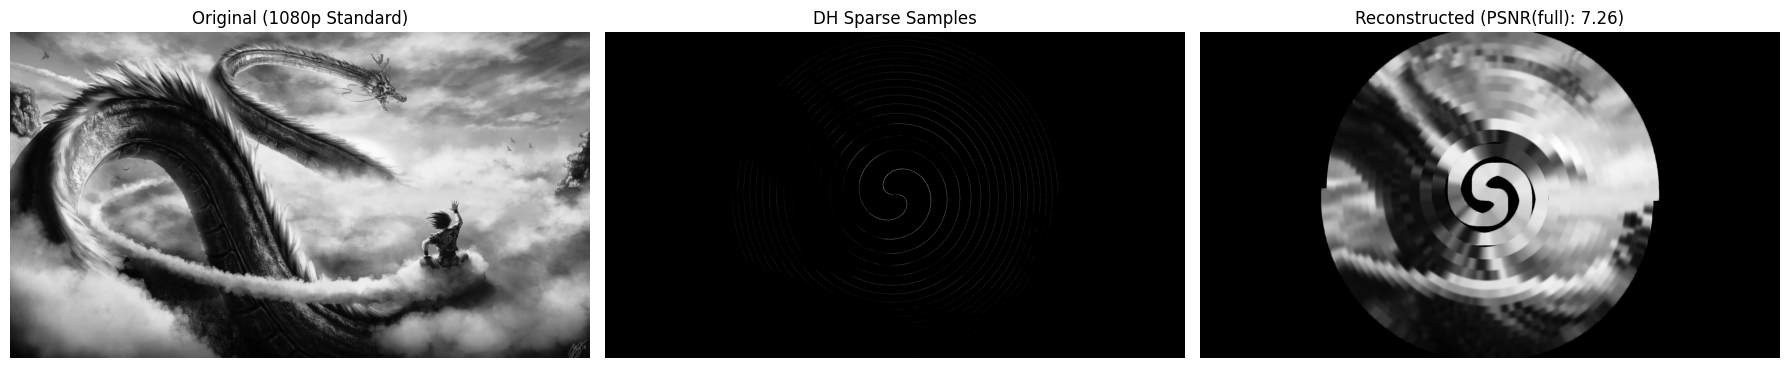

DH Reconstruction :
- PSNR (Full):  7.2612 dB
- SSIM (Full):  0.3134
- PSNR (Fovea): 12.2647 dB   (ratio=0.25)
- SSIM (Fovea): 0.5614      (center crop)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


# --------------------------
# 1) Fovea mask（中心圆形区域）
# --------------------------
def make_fovea_mask(H, W, ratio=0.25):
    cy, cx = H // 2, W // 2
    Y, X = np.ogrid[:H, :W]
    R = ratio * min(H, W)
    return ((X - cx) ** 2 + (Y - cy) ** 2) <= (R ** 2)


# --------------------------
# 2) Normalized Convolution 重建
#   val: 采样值累计图
#   wgt: 采样次数权重图
#   recon = blur(val) / blur(wgt)
# --------------------------
def reconstruct_normalized(alpha, beta, tool, H, W, ksize=41, sigma=0):
    val = np.zeros((H, W), dtype=np.float32)
    wgt = np.zeros((H, W), dtype=np.float32)

    # 统一到 [0,1]
    a = alpha.astype(np.float32) / 255.0
    b = beta.astype(np.float32) / 255.0

    # 累加，避免覆盖（同一点被采到多次就加权）
    val[tool.idx_ya, tool.idx_xa] += a
    wgt[tool.idx_ya, tool.idx_xa] += 1.0

    val[tool.idx_yb, tool.idx_xb] += b
    wgt[tool.idx_yb, tool.idx_xb] += 1.0

    # 高斯扩散（模拟余光/模糊）
    val_blur = cv2.GaussianBlur(val, (ksize, ksize), sigma)
    wgt_blur = cv2.GaussianBlur(wgt, (ksize, ksize), sigma)

    recon = val_blur / (wgt_blur + 1e-6)
    recon = np.clip(recon, 0.0, 1.0)  # float32 [0,1]

    return recon, val, wgt


# --------------------------
# 3) 实验 2：DH Reconstruction（论文版）
# --------------------------
def run_reconstruction_test(tool, image_path="test.jpg", ksize=41, fovea_ratio=0.25):
    target_w, target_h = tool.width, tool.height

    # 读取图片（注意：cv2.imread 是 BGR）
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"无法读取图片: {image_path}")

    # 缩放到 tool 的尺寸
    img_bgr = cv2.resize(img_bgr, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # Ground truth gray（必须和 tool.scan 的 BGR2GRAY 口径一致）
    gray_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # uint8 [0,255]
    gray_f = gray_original.astype(np.float32) / 255.0          # float [0,1]

    # DH 采样
    res = tool.scan(img_bgr)
    alpha = res["alpha_stream"]
    beta  = res["beta_stream"]

    # 重建（Normalized Convolution）
    recon_f, val_map, wgt_map = reconstruct_normalized(alpha, beta, tool, target_h, target_w, ksize=ksize)

    # 指标（Full）
    psnr_full = psnr(gray_f, recon_f, data_range=1.0)
    ssim_full = ssim(gray_f, recon_f, data_range=1.0)

    # 指标（Fovea）
    m = make_fovea_mask(target_h, target_w, ratio=fovea_ratio)
    psnr_fov = psnr(gray_f[m], recon_f[m], data_range=1.0)

    # Fovea 的 SSIM 用 crop 更合理（避免 mask 形式不一致）
    r = int(fovea_ratio * min(target_h, target_w))
    cy, cx = target_h // 2, target_w // 2
    y0, y1 = max(0, cy - r), min(target_h, cy + r)
    x0, x1 = max(0, cx - r), min(target_w, cx + r)
    ssim_fov = ssim(gray_f[y0:y1, x0:x1], recon_f[y0:y1, x0:x1], data_range=1.0)

    # 可视化用 sparse（用 val_map/wgt_map 生成“稀疏点强度图”）
    # 这里用 (val_map / max(wgt,1)) 来显示采样点亮度（未扩散版本）
    sparse_vis = np.zeros_like(gray_f, dtype=np.float32)
    hit = wgt_map > 0
    sparse_vis[hit] = (val_map[hit] / np.maximum(wgt_map[hit], 1.0))

    # 转 uint8 供显示
    recon_show  = (recon_f * 255).astype(np.uint8)
    sparse_show = (sparse_vis * 255).astype(np.uint8)
    orig_show   = gray_original

    # 画图（3 张：原图灰度 / 稀疏点 / 重建）
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original (1080p Standard)")
    plt.imshow(orig_show, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("DH Sparse Samples")
    plt.imshow(sparse_show, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Reconstructed (PSNR(full): {psnr_full:.2f})")
    plt.imshow(recon_show, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("DH Reconstruction :")
    print(f"- PSNR (Full):  {psnr_full:.4f} dB")
    print(f"- SSIM (Full):  {ssim_full:.4f}")
    print(f"- PSNR (Fovea): {psnr_fov:.4f} dB   (ratio={fovea_ratio})")
    print(f"- SSIM (Fovea): {ssim_fov:.4f}      (center crop)")

    return psnr_full, ssim_full, psnr_fov, ssim_fov


# --------------------------
# 4) 运行（文件名固定 test.jpg）
# --------------------------
# 确保你已经有 tool，例如：
# tool = DoubleHelixVisionTool(width=1920, height=1080)

psnr_full, ssim_full, psnr_fov, ssim_fov = run_reconstruction_test(
    tool,
    image_path="test.jpg",  # 不改文件名
    ksize=41,               # 可改 41/51/61 看视觉效果
    fovea_ratio=0.25
)


In [ ]:
import cv2

img_bgr = cv2.imread("test.jpg")
img_bgr = cv2.resize(img_bgr, (tool.width, tool.height), interpolation=cv2.INTER_AREA)

res = tool.scan(img_bgr)

print("N_eff =", len(tool.idx_xa),
      "alpha_len =", len(res["alpha_stream"]),
      "beta_len =", len(res["beta_stream"]))

N_eff = 6000 alpha_len = 6000 beta_len = 6000


DH per-helix N_eff = 6000 | alpha_len = 6000 | beta_len = 6000 | total_budget = 12000
Method          | Full PSNR | Full SSIM | Fovea PSNR | Fovea SSIM
----------------------------------------------------------------------
Random          |    24.13 |    0.765 |      22.73 |      0.692
Double-Helix    |     7.26 |    0.313 |      12.26 |      0.561
----------------------------------------------------------------------
Fovea Gain (DH - Random): PSNR -10.46 dB, SSIM -0.131


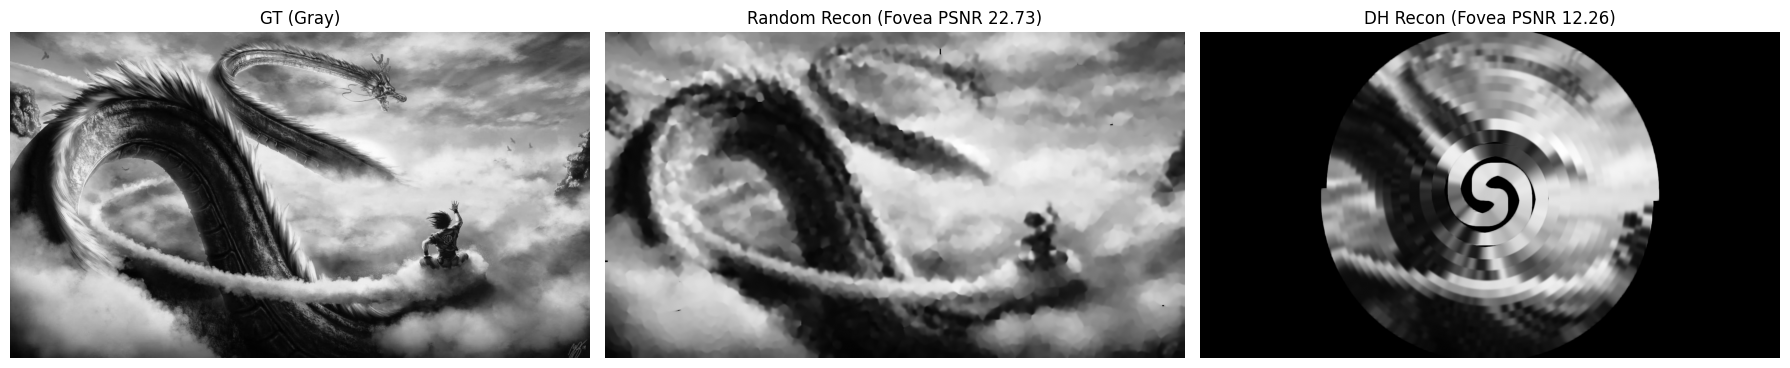

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

np.random.seed(0)

# ---------- 1) 读图 + GT 灰度（口径与 tool.scan 一致：BGR2GRAY） ----------
img_bgr = cv2.imread("test.jpg")
img_bgr = cv2.resize(img_bgr, (tool.width, tool.height), interpolation=cv2.INTER_AREA)

gray_gt_u8 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)              # uint8 [0,255]
gray_gt = gray_gt_u8.astype(np.float32) / 255.0                     # float [0,1]
H, W = gray_gt_u8.shape

# ---------- 2) DH 采样 ----------
res = tool.scan(img_bgr)
alpha = res["alpha_stream"]
beta  = res["beta_stream"]

# 实际预算（最关键：不用写死 2*3000）
budget = len(alpha) + len(beta)
print("DH per-helix N_eff =", len(tool.idx_xa), "| alpha_len =", len(alpha), "| beta_len =", len(beta), "| total_budget =", budget)

# ---------- 3) 统一的 Normalized Convolution 重建（输入任意 coords+values） ----------
def reconstruct_from_points_norm(ys, xs, vals_u8, H, W, ksize=41, sigma=0):
    val = np.zeros((H, W), dtype=np.float32)
    wgt = np.zeros((H, W), dtype=np.float32)

    v = vals_u8.astype(np.float32) / 255.0
    val[ys, xs] += v
    wgt[ys, xs] += 1.0

    val_blur = cv2.GaussianBlur(val, (ksize, ksize), sigma)
    wgt_blur = cv2.GaussianBlur(wgt, (ksize, ksize), sigma)

    recon = val_blur / (wgt_blur + 1e-6)
    return np.clip(recon, 0.0, 1.0)  # float [0,1]

def make_fovea_mask(H, W, ratio=0.25):
    cy, cx = H // 2, W // 2
    Y, X = np.ogrid[:H, :W]
    R = ratio * min(H, W)
    return ((X - cx) ** 2 + (Y - cy) ** 2) <= (R ** 2)

def metrics(gt, recon, fovea_ratio=0.25):
    # full
    p_full = psnr(gt, recon, data_range=1.0)
    s_full = ssim(gt, recon, data_range=1.0)

    # fovea：PSNR 用 mask；SSIM 用中心 crop（更稳）
    m = make_fovea_mask(H, W, ratio=fovea_ratio)
    p_fov = psnr(gt[m], recon[m], data_range=1.0)

    r = int(fovea_ratio * min(H, W))
    cy, cx = H // 2, W // 2
    y0, y1 = max(0, cy - r), min(H, cy + r)
    x0, x1 = max(0, cx - r), min(W, cx + r)
    s_fov = ssim(gt[y0:y1, x0:x1], recon[y0:y1, x0:x1], data_range=1.0)

    return p_full, s_full, p_fov, s_fov

# ---------- 4) DH 重建（把 alpha+beta 变成统一点集） ----------
ys_dh = np.concatenate([tool.idx_ya, tool.idx_yb])
xs_dh = np.concatenate([tool.idx_xa, tool.idx_xb])
vals_dh = np.concatenate([alpha, beta])

recon_dh = reconstruct_from_points_norm(ys_dh, xs_dh, vals_dh, H, W, ksize=41)
p_dh_full, s_dh_full, p_dh_fov, s_dh_fov = metrics(gray_gt, recon_dh, fovea_ratio=0.25)

# ---------- 5) Random baseline（严格同预算 budget） ----------
ry = np.random.randint(0, H, budget, dtype=np.int32)
rx = np.random.randint(0, W, budget, dtype=np.int32)
vals_r = gray_gt_u8[ry, rx]  # 随机采样到的亮度值（公平：同样来自 GT 灰度）

recon_r = reconstruct_from_points_norm(ry, rx, vals_r, H, W, ksize=41)
p_r_full, s_r_full, p_r_fov, s_r_fov = metrics(gray_gt, recon_r, fovea_ratio=0.25)

# ---------- 6) 打印对比表 ----------
print(f"{'Method':<15} | {'Full PSNR':>8} | {'Full SSIM':>8} | {'Fovea PSNR':>10} | {'Fovea SSIM':>10}")
print("-" * 70)
print(f"{'Random':<15} | {p_r_full:8.2f} | {s_r_full:8.3f} | {p_r_fov:10.2f} | {s_r_fov:10.3f}")
print(f"{'Double-Helix':<15} | {p_dh_full:8.2f} | {s_dh_full:8.3f} | {p_dh_fov:10.2f} | {s_dh_fov:10.3f}")
print("-" * 70)
print(f"Fovea Gain (DH - Random): PSNR {p_dh_fov - p_r_fov:+.2f} dB, SSIM {s_dh_fov - s_r_fov:+.3f}")

# ---------- 7) 可视化（可选但建议：三图对比） ----------
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("GT (Gray)")
plt.imshow(gray_gt_u8, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Random Recon (Fovea PSNR {p_r_fov:.2f})")
plt.imshow((recon_r * 255).astype(np.uint8), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"DH Recon (Fovea PSNR {p_dh_fov:.2f})")
plt.imshow((recon_dh * 255).astype(np.uint8), cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def fovea_mask(H, W, ratio):
    cy, cx = H//2, W//2
    Y, X = np.ogrid[:H, :W]
    R = ratio * min(H, W)
    return ((X-cx)**2 + (Y-cy)**2) <= (R**2)

H, W = gray_gt.shape
ratios = [0.05, 0.08, 0.10, 0.15, 0.25]

print(f"{'ratio':>6} | {'DH_pts':>7} | {'Rnd_pts':>7} | {'DH_PSNR':>8} | {'Rnd_PSNR':>8} | {'Gain':>8}")
print("-"*65)

for r in ratios:
    m = fovea_mask(H, W, r)

    # 统计该 fovea 内的采样点数
    dh_in = int(np.sum(m[ys_dh, xs_dh]))
    rnd_in = int(np.sum(m[ry, rx]))

    # 只在该 mask 内算 PSNR（更贴你的“中心评价”）
    dh_p = psnr(gray_gt[m], recon_dh[m], data_range=1.0)
    rd_p = psnr(gray_gt[m], recon_r[m], data_range=1.0)

    print(f"{r:6.2f} | {dh_in:7d} | {rnd_in:7d} | {dh_p:8.2f} | {rd_p:8.2f} | {dh_p-rd_p:8.2f}")


 ratio |  DH_pts | Rnd_pts |  DH_PSNR | Rnd_PSNR |     Gain
-----------------------------------------------------------------
  0.05 |     184 |      42 |     6.61 |    32.76 |   -26.15
  0.08 |     430 |     114 |     5.83 |    32.19 |   -26.36
  0.10 |     648 |     182 |     6.11 |    27.45 |   -21.34
  0.15 |    1346 |     459 |     8.44 |    24.10 |   -15.66
  0.25 |    3414 |    1326 |    12.26 |    22.73 |   -10.46


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset

# 固定随机种子，保证 Random baseline 可复现
np.random.seed(0)
torch.manual_seed(0)

class DHExternalSampler:
    """
    外部采样器：不改 DoubleHelixVisionTool。
    定义：K = 每条螺旋采样点数；总采样预算 = 2K
    """
    def __init__(self, W=32, H=32, K=256, rotations=4, growth=0.55, cx=None, cy=None):
        self.W, self.H, self.K = W, H, K
        self.cx = (W // 2) if cx is None else int(cx)
        self.cy = (H // 2) if cy is None else int(cy)

        # 内切圆半径：保证不越界 -> 不需要 valid_mask -> K 就是有效点数
        r_max = min(self.cx, self.cy, W - 1 - self.cx, H - 1 - self.cy) - 1
        r_max = max(1, r_max)

        thetas = np.linspace(0, rotations * 2 * np.pi, K, dtype=np.float32)
        radii  = r_max * (thetas / (thetas[-1] + 1e-9)) ** growth

        xa = (self.cx + radii * np.cos(thetas)).astype(np.int32)
        ya = (self.cy + radii * np.sin(thetas)).astype(np.int32)
        xb = (self.cx + radii * np.cos(thetas + np.pi)).astype(np.int32)
        yb = (self.cy + radii * np.sin(thetas + np.pi)).astype(np.int32)

        xa = np.clip(xa, 0, W - 1); ya = np.clip(ya, 0, H - 1)
        xb = np.clip(xb, 0, W - 1); yb = np.clip(yb, 0, H - 1)

        # 用“扁平索引”提升采样速度：idx = y*W + x
        self.idx_a = ya * W + xa
        self.idx_b = yb * W + xb

        # 用于 sanity check：有效唯一点数
        self.unique_ratio = len(np.unique(np.concatenate([self.idx_a, self.idx_b]))) / (2 * K)

    @staticmethod
    def rgb_to_gray_u8(img_u8_hwc):
        """
        img_u8_hwc: uint8 [H,W,3] RGB
        return: gray uint8 [H,W]
        """
        r = img_u8_hwc[..., 0].astype(np.float32)
        g = img_u8_hwc[..., 1].astype(np.float32)
        b = img_u8_hwc[..., 2].astype(np.float32)
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return np.clip(gray, 0, 255).astype(np.uint8)

    def sample_dh(self, gray_u8_hw):
        g = gray_u8_hw.reshape(-1)
        a = g[self.idx_a]
        b = g[self.idx_b]
        # 输出 float32 [0,1]，shape = (2, K)
        x = np.stack([a, b], axis=0).astype(np.float32) / 255.0
        return x

    def sample_random(self, gray_u8_hw, rng: np.random.Generator):
        # Random baseline：同预算 2K
        flat = gray_u8_hw.reshape(-1)
        ridx = rng.integers(0, self.W * self.H, size=(2 * self.K,), dtype=np.int32)
        v = flat[ridx].astype(np.float32) / 255.0
        # 拆成两通道 (2,K)，和 DH 输入形状一致
        return v.reshape(2, self.K)


In [ ]:
def build_features_cifar10(K=256, max_train=None, max_test=None, rotations=4, growth=0.55, seed=0):
    """
    返回：
      X_dh_train, y_train, X_dh_test, y_test
      X_r_train,  y_train, X_r_test,  y_test
    形状：X = [N, 2, K] float32
    """
    # CIFAR10 原始数据：uint8 [N,32,32,3] (RGB)
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True)

    Xtr = train_ds.data  # numpy uint8
    ytr = np.array(train_ds.targets, dtype=np.int64)
    Xte = test_ds.data
    yte = np.array(test_ds.targets, dtype=np.int64)

    if max_train is not None:
        Xtr = Xtr[:max_train]
        ytr = ytr[:max_train]
    if max_test is not None:
        Xte = Xte[:max_test]
        yte = yte[:max_test]

    sampler = DHExternalSampler(W=32, H=32, K=K, rotations=rotations, growth=growth)
    print(f"[Sampler] K(per-helix)={K}, total=2K={2*K}, unique_ratio≈{sampler.unique_ratio:.3f}")

    # Random baseline 的 rng（固定种子，保证复现）
    rng_tr = np.random.default_rng(seed)
    rng_te = np.random.default_rng(seed + 1)

    def featurize(X_u8, rng):
        N = X_u8.shape[0]
        X_dh = np.empty((N, 2, K), dtype=np.float32)
        X_r  = np.empty((N, 2, K), dtype=np.float32)

        for i in range(N):
            gray = sampler.rgb_to_gray_u8(X_u8[i])      # [32,32] uint8
            X_dh[i] = sampler.sample_dh(gray)           # (2,K)
            X_r[i]  = sampler.sample_random(gray, rng)  # (2,K)
        return X_dh, X_r

    X_dh_tr, X_r_tr = featurize(Xtr, rng_tr)
    X_dh_te, X_r_te = featurize(Xte, rng_te)

    return (X_dh_tr, ytr, X_dh_te, yte, X_r_tr, ytr, X_r_te, yte)


class Tiny1DCNN(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)


def train_eval(X_train, y_train, X_test, y_test, epochs=15, batch_size=256, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    Xtr = torch.from_numpy(X_train)
    ytr = torch.from_numpy(y_train)
    Xte = torch.from_numpy(X_test)
    yte = torch.from_numpy(y_test)

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

    model = Tiny1DCNN(K=X_train.shape[-1]).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        if ep % 5 == 0:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb).argmax(dim=1)
                    correct += (pred == yb).sum().item()
                    total += yb.size(0)
            print(f"Epoch {ep:02d} | Acc = {100*correct/total:.2f}%")

    # 最终 accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return 100 * correct / total


In [ ]:
# 先快速验证：训练 10k / 测试 10k（测试集本来就是 10k）
K_list = [128, 256]   # 每条螺旋 K（你要的口径）
max_train = 10000     # 快速验证用 10k；稳定后改成 50000
max_test  = 10000

rows = []
for K in K_list:
    X_dh_tr, ytr, X_dh_te, yte, X_r_tr, _, X_r_te, _ = build_features_cifar10(
        K=K, max_train=max_train, max_test=max_test, rotations=4, growth=0.55, seed=0
    )

    print(f"\n=== Train DH (K={K}) ===")
    acc_dh = train_eval(X_dh_tr, ytr, X_dh_te, yte, epochs=15)

    print(f"\n=== Train Random (K={K}) ===")
    acc_r  = train_eval(X_r_tr, ytr, X_r_te, yte, epochs=15)

    rows.append((K, acc_dh, acc_r, acc_dh - acc_r))

print("\nResult Table (per-helix K):")
print(f"{'K':>6} | {'DH Acc':>8} | {'Rnd Acc':>8} | {'Gain':>8}")
print("-"*45)
for K, a, b, g in rows:
    print(f"{K:6d} | {a:8.2f} | {b:8.2f} | {g:8.2f}")


100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


[Sampler] K(per-helix)=128, total=2K=256, unique_ratio≈0.938

=== Train DH (K=128) ===
Epoch 05 | Acc = 18.50%
Epoch 10 | Acc = 19.87%
Epoch 15 | Acc = 20.55%

=== Train Random (K=128) ===
Epoch 05 | Acc = 19.43%
Epoch 10 | Acc = 19.56%
Epoch 15 | Acc = 19.88%
[Sampler] K(per-helix)=256, total=2K=512, unique_ratio≈0.812

=== Train DH (K=256) ===
Epoch 05 | Acc = 19.37%
Epoch 10 | Acc = 21.07%
Epoch 15 | Acc = 21.12%

=== Train Random (K=256) ===
Epoch 05 | Acc = 20.03%
Epoch 10 | Acc = 20.29%
Epoch 15 | Acc = 19.66%

Result Table (per-helix K):
     K |   DH Acc |  Rnd Acc |     Gain
---------------------------------------------
   128 |    20.55 |    19.88 |     0.67
   256 |    21.12 |    19.66 |     1.46


In [ ]:
# ====== 全量训练：50k train / 10k test，重复多个 seed ======

K_list = [128, 256]      # 每条螺旋 K
epochs = 15
seeds = [0, 1, 2]        # 3 次重复，报告 mean±std

final_rows = []

for K in K_list:
    dh_accs = []
    rd_accs = []

    for sd in seeds:
        # 全量：max_train=None => 50k
        X_dh_tr, ytr, X_dh_te, yte, X_r_tr, _, X_r_te, _ = build_features_cifar10(
            K=K, max_train=None, max_test=10000, rotations=4, growth=0.55, seed=sd
        )

        print(f"\n=== K={K} | Seed={sd} | Train DH ===")
        acc_dh = train_eval(X_dh_tr, ytr, X_dh_te, yte, epochs=epochs)

        print(f"\n=== K={K} | Seed={sd} | Train Random ===")
        acc_r  = train_eval(X_r_tr, ytr, X_r_te, yte, epochs=epochs)

        dh_accs.append(acc_dh)
        rd_accs.append(acc_r)

    dh_mean, dh_std = float(np.mean(dh_accs)), float(np.std(dh_accs, ddof=1))
    rd_mean, rd_std = float(np.mean(rd_accs)), float(np.std(rd_accs, ddof=1))
    gain_mean = dh_mean - rd_mean

    final_rows.append((K, dh_mean, dh_std, rd_mean, rd_std, gain_mean))

print("\nFinal Result Table (50k train, per-helix K):")
print(f"{'K':>6} | {'DH Acc':>14} | {'Rnd Acc':>14} | {'Gain':>8}")
print("-"*60)
for K, dh_m, dh_s, rd_m, rd_s, g in final_rows:
    print(f"{K:6d} | {dh_m:6.2f} ± {dh_s:5.2f} | {rd_m:6.2f} ± {rd_s:5.2f} | {g:8.2f}")


[Sampler] K(per-helix)=128, total=2K=256, unique_ratio≈0.938

=== K=128 | Seed=0 | Train DH ===
Epoch 05 | Acc = 23.05%
Epoch 10 | Acc = 25.66%
Epoch 15 | Acc = 27.58%

=== K=128 | Seed=0 | Train Random ===
Epoch 05 | Acc = 20.20%
Epoch 10 | Acc = 20.23%
Epoch 15 | Acc = 20.44%
[Sampler] K(per-helix)=128, total=2K=256, unique_ratio≈0.938

=== K=128 | Seed=1 | Train DH ===
Epoch 05 | Acc = 21.95%
Epoch 10 | Acc = 23.50%
Epoch 15 | Acc = 25.16%

=== K=128 | Seed=1 | Train Random ===
Epoch 05 | Acc = 20.08%
Epoch 10 | Acc = 20.48%
Epoch 15 | Acc = 21.19%
[Sampler] K(per-helix)=128, total=2K=256, unique_ratio≈0.938

=== K=128 | Seed=2 | Train DH ===
Epoch 05 | Acc = 21.89%
Epoch 10 | Acc = 25.25%
Epoch 15 | Acc = 27.20%

=== K=128 | Seed=2 | Train Random ===
Epoch 05 | Acc = 19.92%
Epoch 10 | Acc = 20.20%
Epoch 15 | Acc = 20.23%
[Sampler] K(per-helix)=256, total=2K=512, unique_ratio≈0.812

=== K=256 | Seed=0 | Train DH ===
Epoch 05 | Acc = 22.11%
Epoch 10 | Acc = 23.46%
Epoch 15 | Acc = 24